In [11]:
#
# In this notebook we exampine moprhology's rol,e of preicpitaiton system
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from global_land_mask import globe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from src.regions import *
from src.pf_stats import *
from src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
CORE_THRESH = 10

pf_stats = load_global_pf_stats()

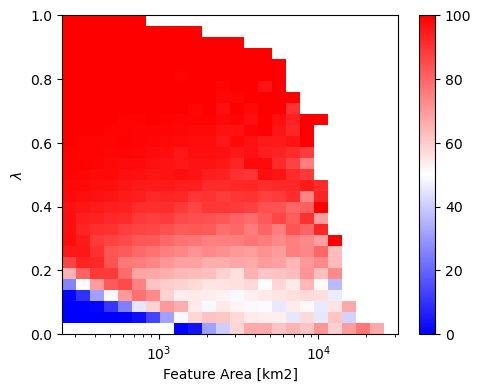

In [18]:
#
# We make a figure of the fraction of PSs with MaxPr in the rainiest core, and the area fraction of the rainiest core
#
fig, ax = plt.subplots(figsize=(5, 4))


area = pf_stats['num_pixels'] * 25
loc = pf_stats[f'largest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
sigma = pf_stats[f'largest_{CORE_THRESH}mmhr_cluster_size_8conn']/pf_stats['num_pixels']
max_pr = pf_stats['max_precip']
core_max_pr = pf_stats[f'largest_{CORE_THRESH}mmhr_cluster_max_precip_8conn']

area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
sigma_bins = loc_bins.copy()

def plot_maxpr_frac(ax, maxpr, core_max_pr, loc, area):
    core_max = binned_statistic_2d(
        x=loc, 
        y=area, 
        values=(maxpr==core_max_pr), 
        bins=[loc_bins, area_bins], 
        statistic=lambda x: sum(x) if x.size>5 else np.nan
    ).statistic
    
    all_count = binned_statistic_2d(
        x=loc, 
        y=area, 
        values=None, #(maxpr==core_max_pr), # dummy variable
        bins=[loc_bins, area_bins], 
        statistic='count'#lambda x: x.size if x.size>5 else np.nan
    ).statistic

    frac = 100*core_max/all_count
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
            x_mesh, 
            y_mesh, 
            frac, 
            cmap=plt.cm.bwr,#plt.cm.magma, 
            norm=colors.TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)#colors.Normalize(vmin=0, vmax=100)
        )
    ax.set_xscale('log')
    ax.set_xlabel('Feature Area [km2]')
    ax.set_ylabel(r'$\lambda$')
    return c  # Return the mappable object so we can attach a colorbar

#
# Top-left
#
c = plot_maxpr_frac(
    ax=ax, 
    maxpr=max_pr, 
    core_max_pr=core_max_pr,
    loc=loc,
    area=area    
)
fig.colorbar(c, ax=ax)
# ax.set_title('Land', loc='right')
# ax.set_title('Fraction of Systems with MaxPr in Largest Core [%]', loc='center')
# ax.set_title('a', loc='left')

fig.tight_layout(pad=1)
plt.show()


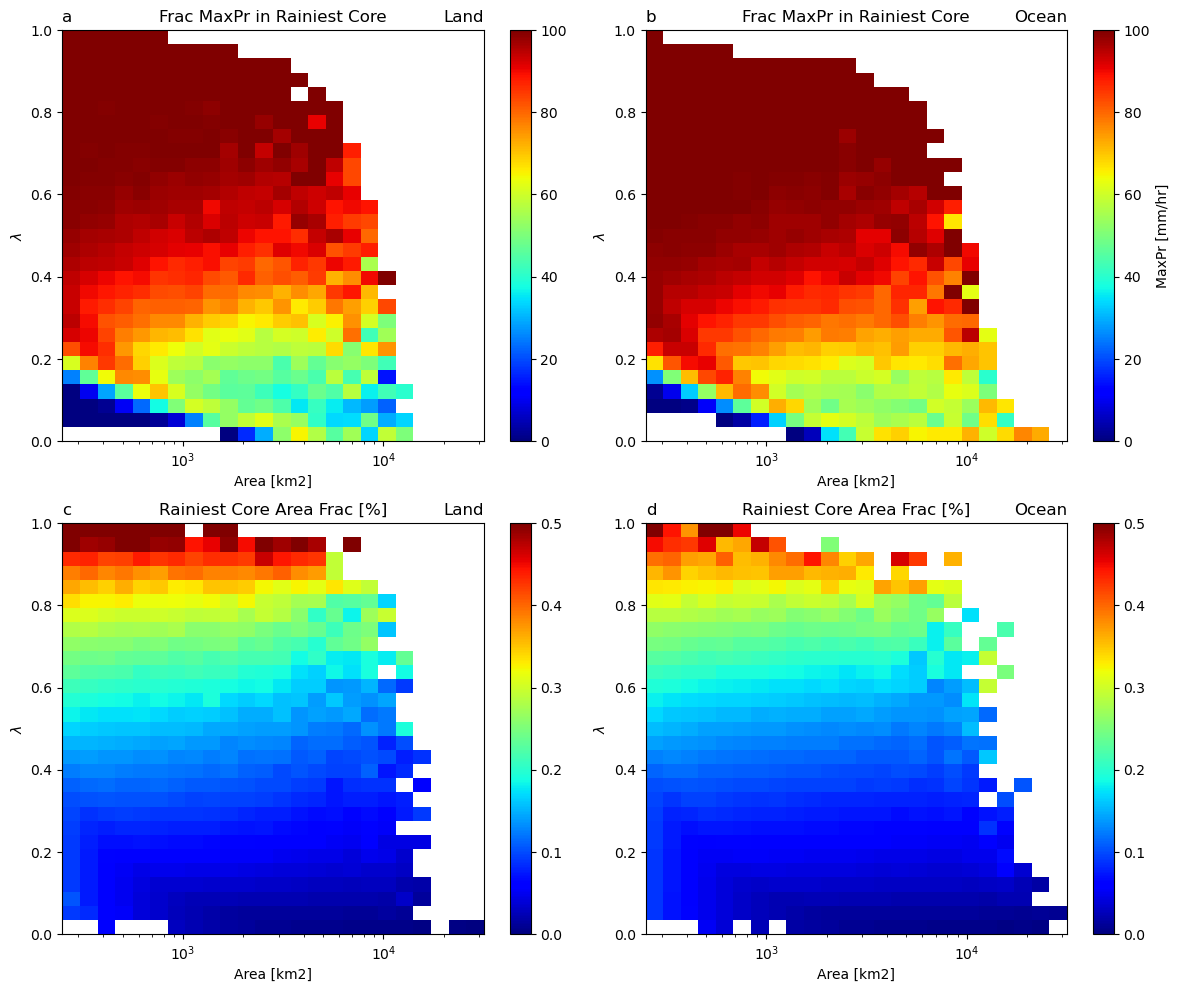

In [4]:
#
# We make a figure of the fraction of PSs with MaxPr in the rainiest core, and the area fraction of the rainiest core
#
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))

is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

area = pf_stats['num_pixels'] * 25
loc = pf_stats[f'largest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
sigma = pf_stats[f'largest_{CORE_THRESH}mmhr_cluster_size_8conn']/pf_stats['num_pixels']
max_pr = pf_stats['max_precip']
core_max_pr = pf_stats[f'largest_{CORE_THRESH}mmhr_cluster_max_precip_8conn']

area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
sigma_bins = loc_bins.copy()

def plot_maxpr_frac(ax, maxpr, core_max_pr, loc, area):
    core_max = binned_statistic_2d(
        x=loc, 
        y=area, 
        values=(maxpr==core_max_pr), 
        bins=[loc_bins, area_bins], 
        statistic=lambda x: sum(x) if x.size>5 else np.nan
    ).statistic
    
    all_count = binned_statistic_2d(
        x=loc, 
        y=area, 
        values=maxpr==core_max_pr, 
        bins=[loc_bins, area_bins], 
        statistic=lambda x: x.size if x.size>5 else np.nan
    ).statistic

    frac = 100*core_max/all_count
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
            x_mesh, 
            y_mesh, 
            frac, 
            cmap=plt.cm.jet, 
            norm=colors.Normalize(vmin=0, vmax=100)
        )
    ax.set_xscale('log')
    ax.set_xlabel('Area [km2]')
    ax.set_ylabel(r'$\lambda$')
    return c  # Return the mappable object so we can attach a colorbar

def plot_sigma(ax, loc, area, sigma):
    mean_sigma = binned_statistic_2d(
        x=loc, 
        y=area, 
        values=sigma, 
        bins=[loc_bins, area_bins], 
        statistic=lambda x: np.nanmean(x) if x.size>0 else np.nan
    ).statistic
    
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
            x_mesh, 
            y_mesh, 
            mean_sigma, 
            cmap=plt.cm.jet, 
            norm=colors.Normalize(vmin=0, vmax=0.5)
        ) 
    ax.set_xscale('log')
    ax.set_xlabel('Area [km2]')
    ax.set_ylabel(r'$\lambda$')
    return c  # Return the mappable object so we can attach a colorbar

#
# Top-left
#
ax = axs[0,0]
ax.set_title('Land')
c = plot_maxpr_frac(
    ax=ax, 
    maxpr=max_pr[is_land_id], 
    core_max_pr=core_max_pr[is_land_id],
    loc=loc[is_land_id],
    area=area[is_land_id]    
)
fig.colorbar(c, ax=ax)
ax.set_title('Land', loc='right')
ax.set_title('Frac MaxPr in Rainiest Core', loc='center')
ax.set_title('a', loc='left')

#
# Top-right
#
ax = axs[0,1]
c = plot_maxpr_frac(
    ax=ax, 
    maxpr=max_pr[is_ocean_id], 
    core_max_pr=core_max_pr[is_ocean_id],
    loc=loc[is_ocean_id],
    area=area[is_ocean_id]    
)
fig.colorbar(c, ax=ax, label='MaxPr [mm/hr]')
ax.set_title('Ocean', loc='right')
ax.set_title('Frac MaxPr in Rainiest Core', loc='center')
ax.set_title('b', loc='left')

#
# Bottom-left
#
ax = axs[1,0]
c = plot_sigma(
    ax=ax, 
    loc=loc[is_land_id],
    sigma=sigma[is_land_id], 
    area=area[is_land_id]
)
fig.colorbar(c, ax=ax)
ax.set_title('Land', loc='right')
ax.set_title('Rainiest Core Area Frac [%]', loc='center')
ax.set_title('c', loc='left')

#
# Bottom-right
#
ax = axs[1,1]
ax.set_title('Ocean')
c = plot_sigma(
    ax=ax, 
    loc=loc[is_ocean_id],
    sigma=sigma[is_ocean_id], 
    area=area[is_ocean_id]
)
cb = fig.colorbar(c, ax=ax)

ax.set_title('Ocean', loc='right')
ax.set_title('Rainiest Core Area Frac [%]', loc='center')
ax.set_title('d', loc='left')

fig.tight_layout(pad=1)
plt.show()
